# COMP7705 Project: (Re-)Imag(in)ing Price Trends

This jupyter notebook is composed of 5 parts.

1. Data processing
2. Baseline model (including model construction, training and testing)
3. Sensitivity analysis
4. Grad-CAM
5. Regression model


# GetData from local files (implemented additionally)


# Labels (implemented additionally)

# Data Preprocess

In [22]:
# unzip the file
import os
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt



image_dir = r"/kaggle/input/gooddata/gooddata/"
csv_file = r"/kaggle/input/gooddata/gooddata/labels.csv"

# # Load the CSV data
# data_df_original = pd.read_csv(csv_file)

# # 按股票代码分组并按时间排序
# data_df = data_df_original.groupby('Stock Code').apply(lambda x: x.sort_values(['Year', 'Week'])).reset_index(drop=True)

# # 对每个分组应用shift操作，但不填充缺失值，任其为NaN
# data_df['Rise_Shifted'] = data_df.groupby('Stock Code')['Rise'].shift(-1)
# # data_df['Rise_Shifted'] = data_df.groupby('Stock Code')['Rise']  

# # 将每个分组中最后一行的'Label_Shifted'设置为NaN
# data_df.loc[data_df.groupby('Stock Code')['Rise_Shifted'].cumcount() == 0, 'Rise_Shifted'] = pd.NA

# # 删除每个分组中最后一行，因为它们的'Label_Shifted'是NaN
# data_df = data_df.dropna(subset=['Rise_Shifted'])

# # 显示结果
# print(data_df[['Stock Code', 'Rise', 'Rise_Shifted']])

# # 用Label_Shifted替代原来的Label列，并重命名
# data_df['Rise'] = data_df['Rise_Shifted']
# data_df.drop(columns=['Rise_Shifted'], inplace=True)

# # 显示结果
# print(data_df[['Stock Code', 'Year', 'Week', 'Rise']])

# # 保存为CSV文件
# data_df.to_csv('sorted_data.csv', index=False)


# 加载 CSV 数据
data_df_original = pd.read_csv(csv_file)

# 按股票代码分组并按时间排序
data_df = data_df_original.groupby('Stock Code').apply(lambda x: x.sort_values(['Year', 'Week'])).reset_index(drop=True)

# 显示结果
print(data_df[['Stock Code', 'Year', 'Week', 'Rise']])

# 保存为 CSV 文件
data_df.to_csv('sorted_data.csv', index=False)

# Check the number of missing values in each column
data_df.isnull().sum()

# Create empty lists to store the image data and labels
image_data = []
labels = []

# Iterate through the CSV rows
for index, row in data_df.iterrows():
    stock_code = row["Stock Code"]
    year = row["Year"]
    week = row["Week"]

    # Construct the image filename
    image_filename = f"chart_{stock_code}_{year}_{week}.png"
    image_path = os.path.join(image_dir, image_filename)

    # Open and convert the image to binary format
    # image augmentation resizing
    image = Image.open(image_path)
#     image = image.resize((207, 101))
    image = image.resize((101, 207))
    image = image.convert('L')
    image_array = np.array(image)

    # Append the image data and label to the lists
    image_data.append(image_array)
    labels.append(row["Rise"])

# Convert the lists to NumPy arrays
image_data = np.array(image_data)
labels = np.array(labels)

# Split the data into training and testing sets (80:20 ratio)
split_ratio = 0.8
split_index = int(len(image_data) * split_ratio)

image_train_val_data = image_data[:split_index]
label_train_val_data = labels[:split_index]
image_test_data = image_data[split_index:]
label_test_data = labels[split_index:]

# Print the shape of the training and testing sets
print("Training Images:", image_train_val_data.shape)
print("Training Labels:", label_train_val_data.shape)
print("Testing Images:", image_test_data.shape)
print("Testing Labels:", label_test_data.shape)

import copy
data_df_temp = copy.deepcopy(data_df)

/tmp/ipykernel_34/3979307252.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_df = data_df_original.groupby('Stock Code').apply(lambda x: x.sort_values(['Year', 'Week'])).reset_index(drop=True)


     Stock Code  Year  Week  Rise
0     000001.SS  2015    15   1.0
1     000001.SS  2015    16   1.0
2     000001.SS  2015    17   0.0
3     000001.SS  2015    18   0.0
4     000001.SS  2015    19   0.0
...         ...   ...   ...   ...
4932  ^STOXX50E  2019    48   1.0
4933  ^STOXX50E  2019    49   1.0
4934  ^STOXX50E  2019    50   1.0
4935  ^STOXX50E  2019    51   1.0
4936  ^STOXX50E  2019    52   1.0

[4937 rows x 4 columns]
Training Images: (3949, 101, 207)
Training Labels: (3949,)
Testing Images: (988, 101, 207)
Testing Labels: (988,)


In [23]:
data_df

,Stock Code,Year,Week,Rise,Return
0,000001.SS,2015,15,1.0,0.040173
1,000001.SS,2015,16,1.0,0.041879
2,000001.SS,2015,17,0.0,-0.018938
3,000001.SS,2015,18,0.0,-0.061276
4,000001.SS,2015,19,0.0,-0.005744
...,...,...,...,...,...
4932,^STOXX50E,2019,48,1.0,0.018110
4933,^STOXX50E,2019,49,1.0,0.016037
4934,^STOXX50E,2019,50,1.0,0.001013
4935,^STOXX50E,2019,51,1.0,0.001485


## Data EDA

In [24]:
data_df["Rise"] = data_df["Rise"].astype(int)
data_df.rename(columns={'Rise':'Label'},inplace=True)
data_df.tail(10)

,Stock Code,Year,Week,Label,Return
4927,^STOXX50E,2019,43,0,-0.000538
4928,^STOXX50E,2019,44,1,0.009396
4929,^STOXX50E,2019,45,1,0.004001
4930,^STOXX50E,2019,46,0,-0.004750
4931,^STOXX50E,2019,47,0,-0.001106
4932,^STOXX50E,2019,48,1,0.018110
4933,^STOXX50E,2019,49,1,0.016037
4934,^STOXX50E,2019,50,1,0.001013
4935,^STOXX50E,2019,51,1,0.001485
4936,^STOXX50E,2019,52,1,0.006643


In [25]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4937 entries, 0 to 4936
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Stock Code  4937 non-null   object 
 1   Year        4937 non-null   int64  
 2   Week        4937 non-null   int64  
 3   Label       4937 non-null   int64  
 4   Return      4937 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 193.0+ KB


In [26]:
data_df['Label'].value_counts()

Label
1    2787
0    2150
Name: count, dtype: int64

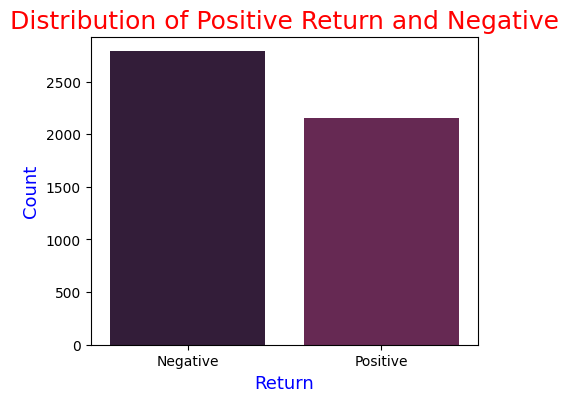

In [27]:
import seaborn as sns
df_cp = data_df.copy()
df_cp['Label'] = df_cp['Label'].replace({0: 'Positive', 1: 'Negative'})
sns.set_palette("rocket")
fig, ax = plt.subplots(figsize=(5,4))
bar = sns.countplot(x=df_cp["Label"],ax=ax)
bar.set_title('Distribution of Positive Return and Negative', fontsize = 18, color = 'red')
bar.set_xlabel('Return', fontsize = 13, color = 'blue')
bar.set_ylabel('Count', fontsize = 13, color ='blue')
plt.show()

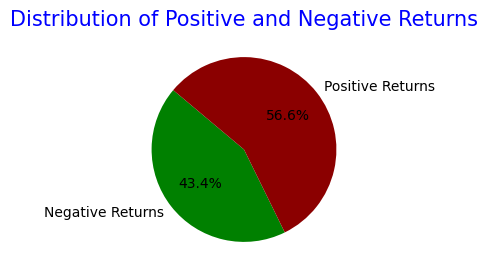

In [28]:
# Count occurrences of positive and negative returns
positive_count = (df_cp["Return"] >= 0).sum()
negative_count = (df_cp["Return"] < 0).sum()

# Create a pie chart for positive and negative returns
sizes = [negative_count, positive_count]
labels = ['Negative Returns', 'Positive Returns']
colors = ['green', 'darkred']

plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Positive and Negative Returns", fontsize=15, color='blue')

plt.show()

## CNN baseline model

In [29]:
cold_start = True

if cold_start:
  #image_train_val_data = np.concatenate(image_train_val_arr, 0)
  image_train_val_data[image_train_val_data==255]=1
  #label_train_val_data = np.concatenate(label_train_val_arr, 0)

  image_train_data, image_val_data = image_train_val_data[:int(0.7*len(image_train_val_data))], image_train_val_data[int(0.7*len(image_train_val_data)):]
  label_train_data, label_val_data = label_train_val_data[:int(0.7*len(label_train_val_data))], label_train_val_data[int(0.7*len(label_train_val_data)):]

  np.save('train_x.npy', image_train_data)
  np.save('train_y.npy', label_train_data)
  np.save('val_x.npy', image_val_data)
  np.save('val_y.npy', label_val_data)

  #image_test_data = np.concatenate(image_test_arr, 0)
  image_test_data[image_test_data==255]=1
  #label_test_data = np.concatenate(label_test_arr, 0)

  np.save('test_x.npy', image_test_data)
  np.save('test_y.npy', label_test_data)

else:
  image_train_data = np.load("train_x.npy")
  image_val_data = np.load("val_x.npy")
  label_train_data = np.load("train_y.npy")
  label_val_data = np.load("val_y.npy")
  image_test_data = np.load("test_x.npy")
  label_test_data = np.load("test_y.npy")

In [30]:
print("The size of training image is " + str(image_train_data.shape))
print("The size of training label is " + str(label_train_data.shape))
print("The size of validation image is " + str(image_val_data.shape))
print("The size of validation label is " + str(label_val_data.shape))
print("The size of testing image is " + str(image_test_data.shape))
print("The size of testing label is " + str(label_test_data.shape))

The size of training image is (2764, 101, 207)
The size of training label is (2764,)
The size of validation image is (1185, 101, 207)
The size of validation label is (1185,)
The size of testing image is (988, 101, 207)
The size of testing label is (988,)


In [31]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch

class ImageDataset(Dataset):
    def __init__(self, data_file_path, label_file_path, binary=True):
        self.data = np.load(data_file_path)
        self.label = np.load(label_file_path)
        self.binary = binary
    def __getitem__(self, index):
        x = self.data[index]
        y = self.label[index]
        x = torch.from_numpy(x).float()
        x = x.unsqueeze(0)
        if self.binary:
            y = np.where(y > 0, 1, 0)
        y = torch.from_numpy(y).float()
        return x, y

    def __len__(self):
        return len(self.data)

class ImgDataset(Dataset):
    def __init__(self, data_file, label_file, binary=True):
        self.data = data_file
        self.label = label_file
        self.binary = binary
    def __getitem__(self, index):
        x = self.data[index]
        y = self.label[index]
        x = torch.from_numpy(x).float()
        x = x.unsqueeze(0)
        if self.binary:
            y = np.where(y > 0, 1, 0)
        y = torch.from_numpy(y).float()
        return x,y

    def __len__(self):
        return len(self.data)

In [32]:
import torch
from torch import nn
import torch.nn.functional as F
class ConvNet(nn.Module):
    """Encoder for feature embedding"""
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size=(5,3), padding=(0, 1), stride=(1,1) ,dilation=(4,1)),
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU(0.01),
                        nn.MaxPool2d(kernel_size  = (2, 1), stride=(2,1)))
        nn.init.xavier_uniform_(self.layer1[0].weight)
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,kernel_size=(5,3),padding=(0,1), stride=(1,1), dilation=(1,1)),
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(0.01),
                        nn.MaxPool2d(kernel_size  = (2, 1), stride=(2,1)),)
        nn.init.xavier_uniform_(self.layer2[0].weight)
        self.layer3 = nn.Sequential(
                        nn.Conv2d(128,256,kernel_size=(5,3),padding=(0,1), stride=(1,1), dilation=(1,1)),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(0.01),
                        nn.MaxPool2d(kernel_size  = (2, 1), stride=(2,1)),)
        nn.init.xavier_uniform_(self.layer3[0].weight)
        self.layer4 = nn.Sequential(
                        nn.Conv2d(256,512,kernel_size=(5,3),padding=(0,1), stride=(1,1), dilation=(1,1)),
                        nn.BatchNorm2d(512),
                        nn.LeakyReLU(0.01),
                        nn.MaxPool2d(kernel_size  = (2, 1), stride=(2,1)),)
        nn.init.xavier_uniform_(self.layer4[0].weight)
        self.fc1 = nn.Sequential(
            nn.Linear(512*1*207, 2),
            nn.Dropout(p=0.5),
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.shape[0],-1)
        result = self.fc1(out)
        result = self.softmax(result)

        return result

def conv3():
    return ConvNet()

model = conv3()
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 3), stride=(1, 1), padding=(0, 1), dilation=(4, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(0, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 1), padding=(0, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=Fal

In [33]:
# class ConvNet1(nn.Module):
#     """Encoder for feature embedding"""
#     def __init__(self):
#         super(ConvNet1, self).__init__()
#         self.layer1 = nn.Sequential(
#                         nn.Conv2d(1, 64, kernel_size=(5,9), padding=(0, 0), stride=(1,1) ,dilation=(4,8)),
#                         nn.BatchNorm2d(64),
#                         nn.LeakyReLU(0.01),
#                         nn.MaxPool2d(kernel_size  = (2, 2), stride=(2,2)))
#         nn.init.xavier_uniform_(self.layer1[0].weight)
#         self.layer2 = nn.Sequential(
#                         nn.Conv2d(64,128,kernel_size=(5,9),padding=(0,0), stride=(1,1), dilation=(1,1)),
#                         nn.BatchNorm2d(128),
#                         nn.LeakyReLU(0.01),
#                         nn.MaxPool2d(kernel_size  = (2, 2), stride=(2,2)),)
#         nn.init.xavier_uniform_(self.layer2[0].weight)
#         self.layer3 = nn.Sequential(
#                         nn.Conv2d(128,256,kernel_size=(5,9),padding=(0,0), stride=(1,1), dilation=(1,1)),
#                         nn.BatchNorm2d(256),
#                         nn.LeakyReLU(0.01),
#                         nn.MaxPool2d(kernel_size  = (2, 2), stride=(2,2)),)
#         nn.init.xavier_uniform_(self.layer3[0].weight)
#         self.layer4 = nn.Sequential(
#                         nn.Conv2d(256,512,kernel_size=(5,9),padding=(0,0), stride=(1,1), dilation=(1,1)),
#                         nn.BatchNorm2d(512),
#                         nn.LeakyReLU(0.01),
#                         nn.MaxPool2d(kernel_size  = (2, 2), stride=(2,2)),)
#         nn.init.xavier_uniform_(self.layer4[0].weight)
#         self.fc1 = nn.Sequential(
#             nn.Linear(512, 2),
#             nn.Dropout(p=0.5),
#         )
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self,x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = out.view(out.shape[0],-1)
#         result = self.fc1(out)
#         result = self.softmax(result)

#         return result

# def conv4():
#     return ConvNet1()

# model = conv4()
# print(model)

In [34]:
!pip install torchsummary
from torchsummary import summary
summary(model.to('cuda'), input_size=(1, 101, 207), device="cuda" )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 85, 207]           1,024
       BatchNorm2d-2          [-1, 64, 85, 207]             128
         LeakyReLU-3          [-1, 64, 85, 207]               0
         MaxPool2d-4          [-1, 64, 42, 207]               0
            Conv2d-5         [-1, 128, 38, 207]         123,008
       BatchNorm2d-6         [-1, 128, 38, 207]             256
         LeakyReLU-7         [-1, 128, 38, 207]               0
         MaxPool2d-8         [-1, 128, 19, 207]               0
            Conv2d-9         [-1, 256, 15, 207]         491,776
      BatchNorm2d-10         [-1, 256, 15, 207]             512
        LeakyReLU-11         [-1, 256, 15, 207]               0
        MaxPool2d-12          [-1, 256, 7, 207]               0
           Conv2d-13          [-1, 512, 3, 207]       1,966,592
      BatchNorm2d-14          [-1, 512,

In [35]:
import torch
import numpy as np
import random
import os
from copy import deepcopy
import math
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

class Averager():

    def __init__(self):
        self.n = 0
        self.v = 0

    def add(self, x):
        self.v = (self.v * self.n + x) / (self.n + 1)
        self.n += 1

    def item(self):
        return self.v


def pretrain(model, loader, optimizer, device):
    model.train()
    ## training with ce
    loss_avg = Averager()
    for batch_idx, batch in enumerate(loader):
        model.zero_grad()
        optimizer.zero_grad()
        train_inputs, train_targets = batch[0], batch[1]
        train_targets = train_targets.long()
        train_inputs = train_inputs.to(device=device)
        train_targets = train_targets.to(device=device)
        train_logits = model(train_inputs)
        loss = nn.CrossEntropyLoss()(train_logits, train_targets)
        loss_avg.add(loss.item())
        loss.backward()
        optimizer.step()
    print("Train Loss %.4f" % (loss_avg.item()))
    return loss_avg.item()

def evaluate_batch(model, data_loader, device):
    model.eval()
    correct = num = 0
    for iter, pack in enumerate(data_loader):
        data, target = pack[0].to(device), pack[1].to(device)
        targets = target.long()
        logits = model(data)
        _, pred = logits.max(1)
        correct += pred.eq(target).sum().item()
        num += data.shape[0]
    torch.cuda.empty_cache()
    model.train()
    return correct/num


def get_confusion(model, data_loader, device):
    model.eval()
    correct = num = 0
    y_true = []
    y_pred = []
    for iter, pack in enumerate(data_loader):
        data, target = pack[0].to(device), pack[1].to(device)
        targets = target.long()
        logits = model(data)
        _, pred = logits.max(1)
        y_true.append(target.item())
        y_pred.append(pred.item())
        correct += pred.eq(target).sum().item()
        num += data.shape[0]
    torch.cuda.empty_cache()
    print(y_true)
    print(y_pred)
    model.train()
    return confusion_matrix(y_true, y_pred)

# Original training and validation 
( pretrained model already generated and saved hence ignored )

Epoch :  1
Train Loss 0.6702
Val Acc :  0.714406779661017
Epoch :  2
Train Loss 0.6252
Val Acc :  0.7067796610169491
Epoch :  3
Train Loss 0.6169
Val Acc :  0.711864406779661
Epoch :  4
Train Loss 0.5975
Val Acc :  0.7
Epoch :  5
Train Loss 0.5795
Val Acc :  0.7135593220338983
Epoch :  6
Train Loss 0.5762
Val Acc :  0.688135593220339
Epoch :  7
Train Loss 0.5693
Val Acc :  0.7135593220338983
Epoch :  8
Train Loss 0.5497
Val Acc :  0.6805084745762712
Epoch :  9
Train Loss 0.5375
Val Acc :  0.7025423728813559
Epoch :  10
Train Loss 0.5223
Val Acc :  0.6576271186440678
Epoch :  11
Train Loss 0.5198
Val Acc :  0.7
Epoch :  12
Train Loss 0.4990
Val Acc :  0.6966101694915254
Epoch :  13
Train Loss 0.4846
Val Acc :  0.7
Epoch :  14
Train Loss 0.4786
Val Acc :  0.6864406779661016
Epoch :  15
Train Loss 0.4688
Val Acc :  0.6847457627118644
Epoch :  16
Train Loss 0.4657
Val Acc :  0.6771186440677966
Epoch :  17
Train Loss 0.4563
Val Acc :  0.7016949152542373
Epoch :  18
Train Loss 0.4520
Val Acc

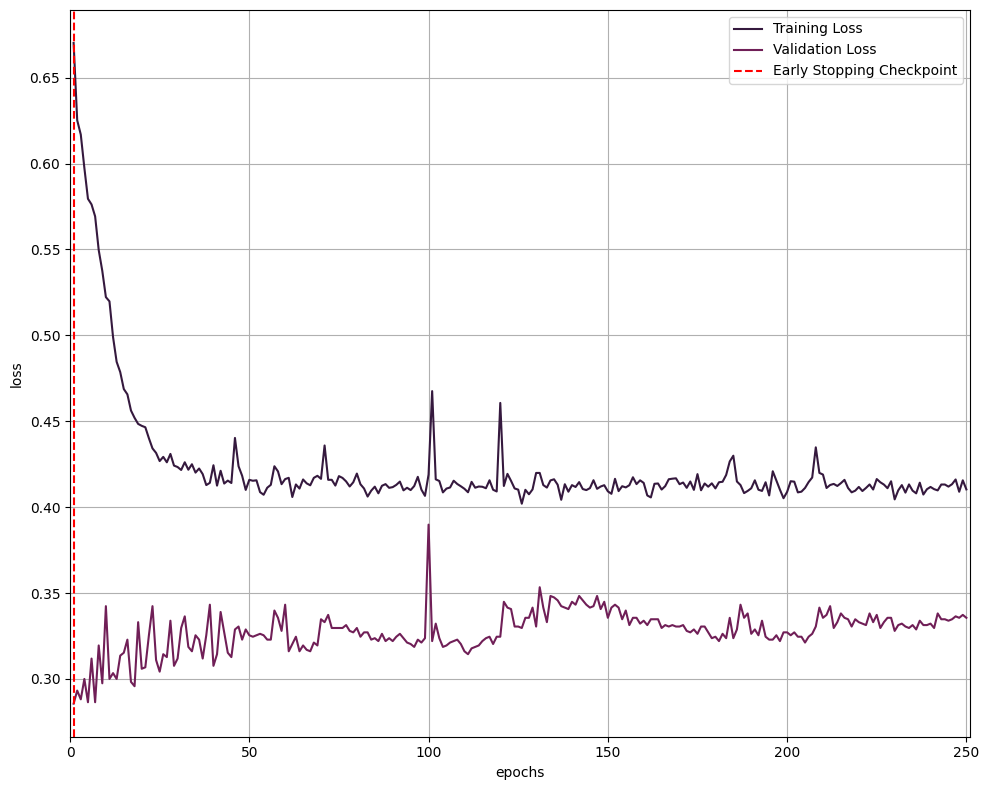

In [36]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import  os

trainset = ImageDataset("train_x.npy","train_y.npy")
valset = ImageDataset("val_x.npy","val_y.npy")

batch_size = 10
epoch = 250
lr = 1e-5
wd =  5e-4
model_name = 'weight.pth'
train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=0,
                pin_memory=True, drop_last=True)
val_loader = DataLoader(dataset=valset, batch_size=batch_size, shuffle=False, num_workers=0,
                pin_memory=True, drop_last=True)




device = 'cuda'
model = conv3().cuda()
# device = 'cpu'
# model = conv3()
optimizer=torch.optim.AdamW(model.parameters(), lr, weight_decay=wd)
evaluate_batch(model, val_loader, device)
best_acc = 0
count = 0

train_losses = []
valid_losses = []

for i in range(1, epoch+1):
    print('Epoch : ', i)
    train_loss = pretrain(model, train_loader, optimizer, device)
    train_losses.append(train_loss)
    val_acc = evaluate_batch(model, val_loader, device)
    valid_losses.append(1-val_acc)
    print('Val Acc : ', val_acc)
    if  best_acc < val_acc:
        count = 0
        best_acc = val_acc
        torch.save(model.state_dict(), model_name)
    else:
        count += 1
    # if count >= 4:
    #     break

# 保存最后一次训练模型
torch.save(model.state_dict(), 'weight_lasttrained.pth')

# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_losses)+1),train_losses, label='Training Loss')
plt.plot(range(1,len(valid_losses)+1),valid_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_losses.index(min(valid_losses))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
# plt.ylim(0, 1) # consistent scale
plt.xlim(0, len(train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

# Additional epochs for training and validation （ Repeat running part for free )

In [37]:
# import torch
# from torch.utils.data import Dataset, DataLoader
# import pandas as pd
# import  os

# trainset = ImageDataset("train_x.npy","train_y.npy")
# valset = ImageDataset("val_x.npy","val_y.npy")

# batch_size = 10
# epoch = 250
# lr = 1e-5
# wd =  5e-4
# model_name = 'weight.pth'
# train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=0,
#                 pin_memory=True, drop_last=True)
# val_loader = DataLoader(dataset=valset, batch_size=batch_size, shuffle=False, num_workers=0,
#                 pin_memory=True, drop_last=True)

# device = 'cuda'
# model = conv3().cuda()
# optimizer=torch.optim.AdamW(model.parameters(), lr, weight_decay=wd)
# evaluate_batch(model, val_loader, device)
# best_acc = 0
# count = 0


# # 继续训练的额外 epoch 数量
# additional_epochs = 100

# # 用于记录继续训练期间的损失
# continue_train_losses = []
# continue_valid_losses = []

# # 从上一次训练的最后模型权重开始
# # model.load_state_dict(torch.load('/kaggle/input/weight-loaded/weight_lasttrained.pth'))
# model.load_state_dict(torch.load('/kaggle/working/weight_lasttrained.pth'))

# for i in range(epoch + 1, epoch + additional_epochs + 1):
#     print(f'Continued Training Epoch : {i}')
    
#     # 训练模型一个 epoch
#     train_loss = pretrain(model, train_loader, optimizer, device)
#     continue_train_losses.append(train_loss)
    
#     # 在验证集上评估模型
#     val_acc = evaluate_batch(model, val_loader, device)
#     continue_valid_losses.append(1 - val_acc)
#     print(f'Val Acc : {val_acc}')
    
#     # 保存每个 epoch 的模型，或者根据需要只保存最佳模型
#     torch.save(model.state_dict(), f'{model_name}_{i}.pth')

# torch.save(model.state_dict(), f'weight_lasttrained.pth')

# # 可视化继续训练期间的训练和验证损失
# fig = plt.figure(figsize=(10, 8))
# plt.plot(range(1, len(continue_train_losses) + 1), continue_train_losses, label='Continued Training Loss')
# plt.plot(range(1, len(continue_valid_losses) + 1), continue_valid_losses, label='Continued Validation Loss')

# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.xlim(0, len(continue_train_losses) + 1)  # 一致的比例
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

# # 保存损失图表
# fig.savefig('loss_plot_continued.png', bbox_inches='tight')



In [38]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Test Acc :  0.7105263157894737
[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0

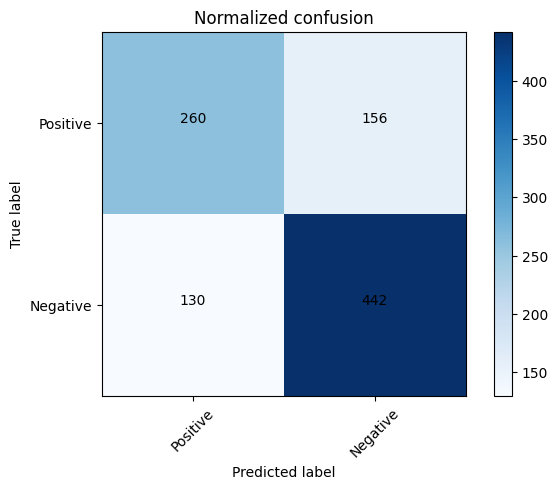

In [39]:
torch.save(model.state_dict(), f'weight_lasttrained.pth')
testset = ImageDataset("test_x.npy","test_y.npy")
batch_size = 1 # for testing
test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=0,
                pin_memory=True, drop_last=True)
test_acc = evaluate_batch(model, test_loader, device)
print('Test Acc : ', test_acc)
test_matrix = get_confusion(model, test_loader, device)
classes = ['Positive', 'Negative']

plot_confusion_matrix(test_matrix, classes=classes, normalize=False, title='Normalized confusion')

In [44]:
y_true = []
y_pred = []
for iter, pack in enumerate(test_loader):
    data, target = pack[0].to(device), pack[1].to(device)
    targets = target.long()
    logits = model(data)
    _, pred = logits.max(1)
    y_true.append(target.item())
    y_pred.append(pred.item())

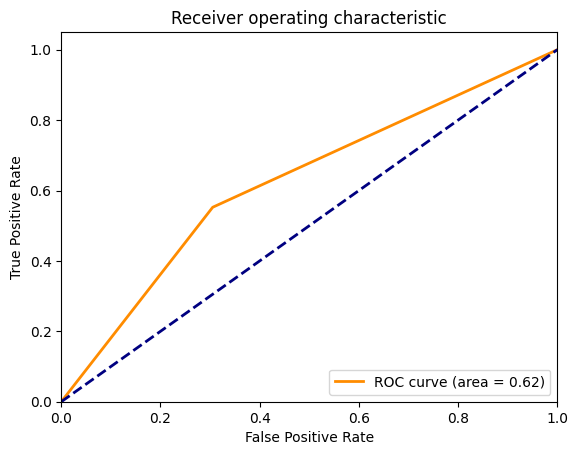

In [45]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [46]:
TN = test_matrix[1][1]
TP = test_matrix[0][0]
FP = test_matrix[0][1]
FN = test_matrix[1][0]

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP+ 1e-9)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN)
f1_score = 2 * (precision * recall) / (precision + recall + 1e-9)

import pandas as pd

data = {'': ['Predicted Positive', 'Predicted Negative'],
        'Actual Positive': [TP, FN],
        'Actual Negative': [FP, TN]}
df1 = pd.DataFrame(data)
df1.set_index('', inplace=True)
df1.loc['Sensitivity',:] = [sensitivity, '']
df1.loc['Specificity',:] = [specificity, '']
df1.loc['F1 score',:] = [f1_score, '']
df1.loc['Accuracy',:] = [accuracy, '']

print(df1)
print('AUC value is: ', roc_auc)

                    Actual Positive Actual Negative
                                                   
Predicted Positive       260.000000           156.0
Predicted Negative       130.000000           442.0
Sensitivity                0.666667                
Specificity                0.739130                
F1 score                   0.645161                
Accuracy                   0.710526                
AUC value is:  0.6235795454545454


/tmp/ipykernel_34/3234987144.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df1.loc['Sensitivity',:] = [sensitivity, '']


### Grad-CAM
please first install the supporting pacakge:

pip install grad-cam

In [48]:
!pip install grad-cam
from pytorch_grad_cam import GradCAM # or ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad

from pytorch_grad_cam.utils.image import show_cam_on_image


batch_size = 1
epoch = 15
lr = 1e-3
wd =  5e-4

train_x  = np.load("train_x.npy")
train_y = np.load("train_y.npy")
val_x , val_y = np.load("val_x.npy"), np.load("val_y.npy")
trainset = ImgDataset(train_x , train_y )
valset = ImgDataset(val_x , val_y)
model_name = "weight.pth"
train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=0,
                pin_memory=True, drop_last=True)
val_loader = DataLoader(dataset=valset, batch_size=batch_size, shuffle=False, num_workers=0,
                pin_memory=True, drop_last=True)

print(valset)
device = 'cuda'

#load the trained model. Here we assume the weight has been saved
model_name = "weight.pth"
model = conv3()
model.load_state_dict(torch.load(model_name,map_location=torch.device('cuda')))
model.eval()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 21.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.2-py3-none-any.whl size=38336 sha256=2ae1f3b2388af2e719da4191c200d8ce3fbacea55ec924af93c4f672885123e0
  Stored in directory: /root/.cache/pip/wheels/b4/68/bb/d10381e86dc0de1c9354bce3d86bffcd247305058c40ce2e55
Successfully built grad-cam


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 3), stride=(1, 1), padding=(0, 1), dilation=(4, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(0, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 1), padding=(0, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=Fal

In [49]:
device = torch.device("cuda")
model.to(device)
# find 5 images that are classified as 1 or 0
classification_object = 1   # or let classification_object = 1 to get another bunch of images
image_list = []
label_list = []
counter = 1
# better shuffle the data loader
for iter, pack in enumerate(val_loader):
    data, target = pack[0].to(device), pack[1].to(device)
    #targets = target.long()
    logits = model(data)
    _, pred = logits.max(1)
    class_list = data[pred==classification_object,]
    # print(class_list)
    if class_list.size(0) > 0:
        obj = class_list[random.randrange(class_list.size(0)),]
        counter = counter+1
        image_list.append(obj)
        if counter >= 5:
            break
# print(image_list)
print(image_list)
if image_list:
    image_list = torch.stack(image_list)

[tensor([[[250., 250., 239.,  ..., 245., 251., 248.],
         [250., 250., 239.,  ..., 245., 251., 248.],
         [250., 250., 239.,  ..., 245., 251., 248.],
         ...,
         [250., 251., 239.,  ..., 245., 251., 247.],
         [250., 251., 240.,  ..., 245., 251., 247.],
         [247., 248., 231.,  ..., 240., 248., 246.]]], device='cuda:0'), tensor([[[241., 241., 232.,  ..., 237., 242., 234.],
         [251., 251., 240.,  ..., 246., 252., 249.],
         [250., 250., 239.,  ..., 245., 251., 248.],
         ...,
         [251., 252., 240.,  ..., 246., 252., 248.],
         [250., 251., 240.,  ..., 245., 251., 247.],
         [247., 248., 231.,  ..., 240., 248., 246.]]], device='cuda:0'), tensor([[[250., 250., 239.,  ..., 245., 251., 248.],
         [250., 250., 239.,  ..., 245., 251., 248.],
         [250., 250., 239.,  ..., 245., 251., 248.],
         ...,
         [245., 246., 235.,  ..., 241., 246., 240.],
         [242., 242., 233.,  ..., 238., 243., 234.],
         [248., 

In [50]:
# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
aug_smooth = True
eigen_smooth = True


target_layer_1 = [model.layer1[-1]]
cam_1 = GradCAM(model=model, target_layers=target_layer_1)
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam_1 = cam_1(input_tensor=image_list, targets=None ,aug_smooth=aug_smooth,eigen_smooth=eigen_smooth)

#visualization = show_cam_on_image(input_tensors, grayscale_cam, use_rgb=True)

target_layer_2 = [model.layer2[-1]]
cam_2 = GradCAM(model=model, target_layers=target_layer_2)
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam_2 = cam_2(input_tensor=image_list, targets=None ,aug_smooth=aug_smooth,eigen_smooth=eigen_smooth)


target_layer_3 = [model.layer3[-1]]
cam_3 = GradCAM(model=model, target_layers=target_layer_3)
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam_3 = cam_3(input_tensor=image_list, targets=None ,aug_smooth=aug_smooth,eigen_smooth=eigen_smooth)

target_layer_4 = [model.layer4[-1]]
cam_4 = GradCAM(model=model, target_layers=target_layer_4)
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam_4 = cam_4(input_tensor=image_list, targets=None ,aug_smooth=aug_smooth,eigen_smooth=eigen_smooth)

grayscale_cam_1 = torch.from_numpy(grayscale_cam_1).to(device)
grayscale_cam_2 = torch.from_numpy(grayscale_cam_2).to(device)
grayscale_cam_3 = torch.from_numpy(grayscale_cam_3).to(device)
grayscale_cam_4 = torch.from_numpy(grayscale_cam_4).to(device)

camera = torch.cat((image_list[:, 0,], grayscale_cam_1, grayscale_cam_2, grayscale_cam_3, grayscale_cam_4), 0)

#camera = torch.cat((image_list[:,0,], torch.from_numpy(grayscale_cam_1),torch.from_numpy(grayscale_cam_2),torch.from_numpy(grayscale_cam_3),torch.from_numpy(grayscale_cam_4)),0)

In [51]:
image_list_cpu = image_list.cpu()
grayscale_cam_1_cpu = grayscale_cam_1.cpu().numpy()
grayscale_cam_2_cpu = grayscale_cam_2.cpu().numpy()
grayscale_cam_3_cpu = grayscale_cam_3.cpu().numpy()
grayscale_cam_4_cpu = grayscale_cam_4.cpu().numpy()

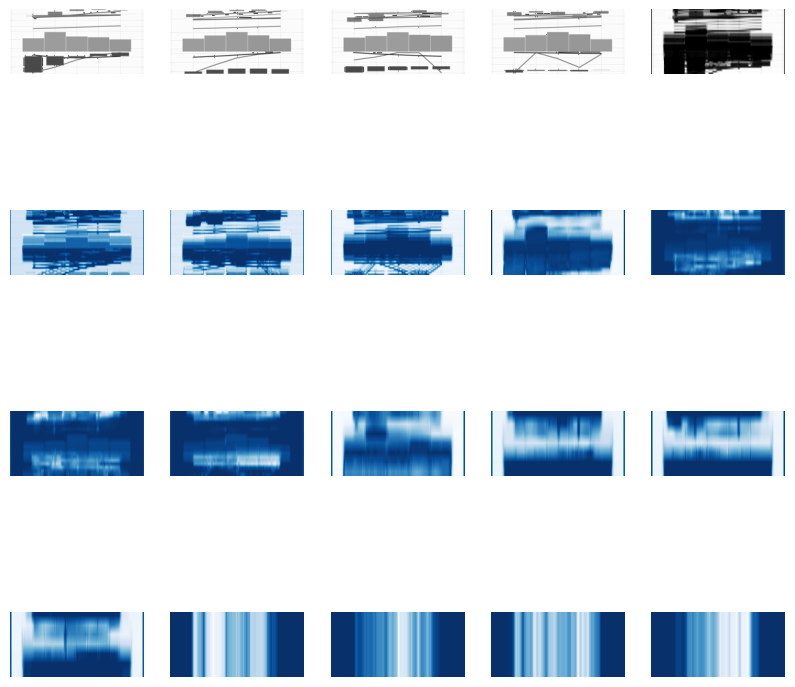

In [52]:
# show multiple images
camera = camera.cpu().numpy()
fig = plt.figure(figsize=(10, 10))
columns = 5
rows = 4
for i in range(0, columns*rows ):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    if i<= 4:
        plt.imshow(camera[i,],cmap="gray")
    else:
        plt.imshow(camera[i,],cmap="Blues_r")
plt.savefig('4x5.png',format='png')
plt.show()
